# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



In [41]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Common library imports:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

# Data Pre-Processing:

For data pre-precessing I initially just read the questions from the file and define an array for each of the party colors, so I can properly use the party colors during later analysis.

In [42]:
# Data pre-processing
## We base our pre-processing on the raw alldata.xlsx information, which includes a complete overview of all the responses associated with each elected candidate and party affiliation.
raw_data = pd.read_excel('electeddata.xlsx')

## Display the head of the raw data, for visual inspection:
display(raw_data.head())

## Since it is a requirement that each party have a specific color, I create a dictionary here, with these colors defined:
party_colors = {
    "Socialdemokratiet": "#b32722",
    "Radikale Venstre": "#713280",
    "Det Konservative Folkeparti": "#9eba27",
    "Nye Borgerlige": "#054f5c",
    "Socialistisk Folkeparti": "#dd0878",
    "Liberal Alliance": "#21c6cf",
    "Kristendemokraterne": "#bababa",
    "Moderaterne": "#6c39e5",
    "Dansk Folkeparti": "#f3cd41",
    "Frie Grønne, Danmarks Nye Venstrefløjsparti": "#00e66a",
    "Venstre": "#006697",
    "Danmarksdemokraterne": "#8ac3ff",
    "Enhedslisten": "#ed8019",
    "Alternativet": "#2a8f39",
    "Løsgænger": "#8c564b"
}

## Here I explicitly define the question_columns and corresponding labels, so I can write the question categories on any visualizations I do:
question_columns = ['1a', '1b', '530', '546', '559', '561', '7a', '7b', '4a', '4b', '531', '541', '545', '550', '556', '8a', '8b', '9a', '9b',
                    '538', '553', '5a', '5b', '537', '540', '543', '548', '557', '2a', '2b', '552', '563', '544', '547', '533', '534', '535',
                    '551', '555', '3a', '3b', '6a', '6b', '10a', '10b', '11a', '11b', '12a', '12b']

question_labels = ['1a [Miljø/Klima]', '1b [Miljø/Klima]', '530 [Miljø/Klima]', '546 [Klima/Energi]', '559 [Klima/Energi]', '561 [Klima/Energi]', '7a [Energi]', '7b [Energi]',
                   '4a [Økonomi]', '4b [Økonomi]', '531 [Arbejdsmarked/Økonomi]', '541 [Arbejdsmarked/Økonomi]', '545 [Arbejdsmarked/Økonomi]', '550 [Arbejdsmarked/Økonomi]',
                   '556 [Arbejdsmarked/Økonomi]', '8a [Børn/Unge]', '8b [Børn/Unge]', '9a [Skole/Uddannelse]', '9b [Skole/Uddannelse]', '538 [Uddannelse]', '553 [Uddannelse]',
                   '5a [Ældre]', '5b [Ældre]', '537 [Velfærd]', '540 [Velfærd]', '543 [Velfærd]', '548 [Velfærd]', '557 [Velfærd]', '2a [Hospice/Sundhed]', '2b [Hospice/Sundhed]',
                   '552 [Sundhed]', '563 [Sundhed]', '544 [Demokrati]', '547 [Demokrati]', '533 [Ret/Straf]', '534 [EU/Udenrigs]', '535 [EU/Udenrigs]', '551 [EU/Udenrigs]',
                   '555 [EU/Udenrigs]', '3a [Udenrigs/Forsvarspolitik]', '3b [Udenrigs/Forsvarspolitik]', '6a [Flygtninge/Indvandring]', '6b [Flygtninge/Indvandring]', '10a [Social]',
                   '10b [Social]', '11a [Mink-Sagen]', '11b [Mink-Sagen]', '12a [Coronavirus]', '12b [Coronavirus]']

,530,531,533,534,535,537,538,540,541,543,...,9a,9b,10a,10b,11a,11b,12a,12b,storkreds,alder
0,2,2,-1,-2,-1,-2,1,-2,2,-2,...,-2,0,-1,2,1,-2,0,0,Fyns Storkreds,64
1,2,2,-2,-2,-2,-2,2,2,2,-2,...,-2,0,-2,2,1,1,0,-2,Østjyllands Storkreds,58
2,2,2,-2,-1,-1,-1,1,-2,2,-2,...,-2,0,-1,2,0,-2,-1,1,Østjyllands Storkreds,30
3,-1,-1,2,-1,2,-1,-2,1,-2,1,...,-1,-1,0,2,-2,2,0,0,Østjyllands Storkreds,53
4,-1,-1,1,-2,2,1,-2,1,-2,1,...,-1,0,1,1,-2,2,1,-1,Østjyllands Storkreds,46


# Data Analysis: Average positions of parties concerning each question, preferably with accompanying plots of each question.

For this assignment, I'll be focusing on the elected candidates - and their question responses.

In order to analyse this first question, I'll use a statistical approach and scatter plot the party averages for each question topic so differences between party averages can be easily observed.


Candidate Average Responses visualized for each party:


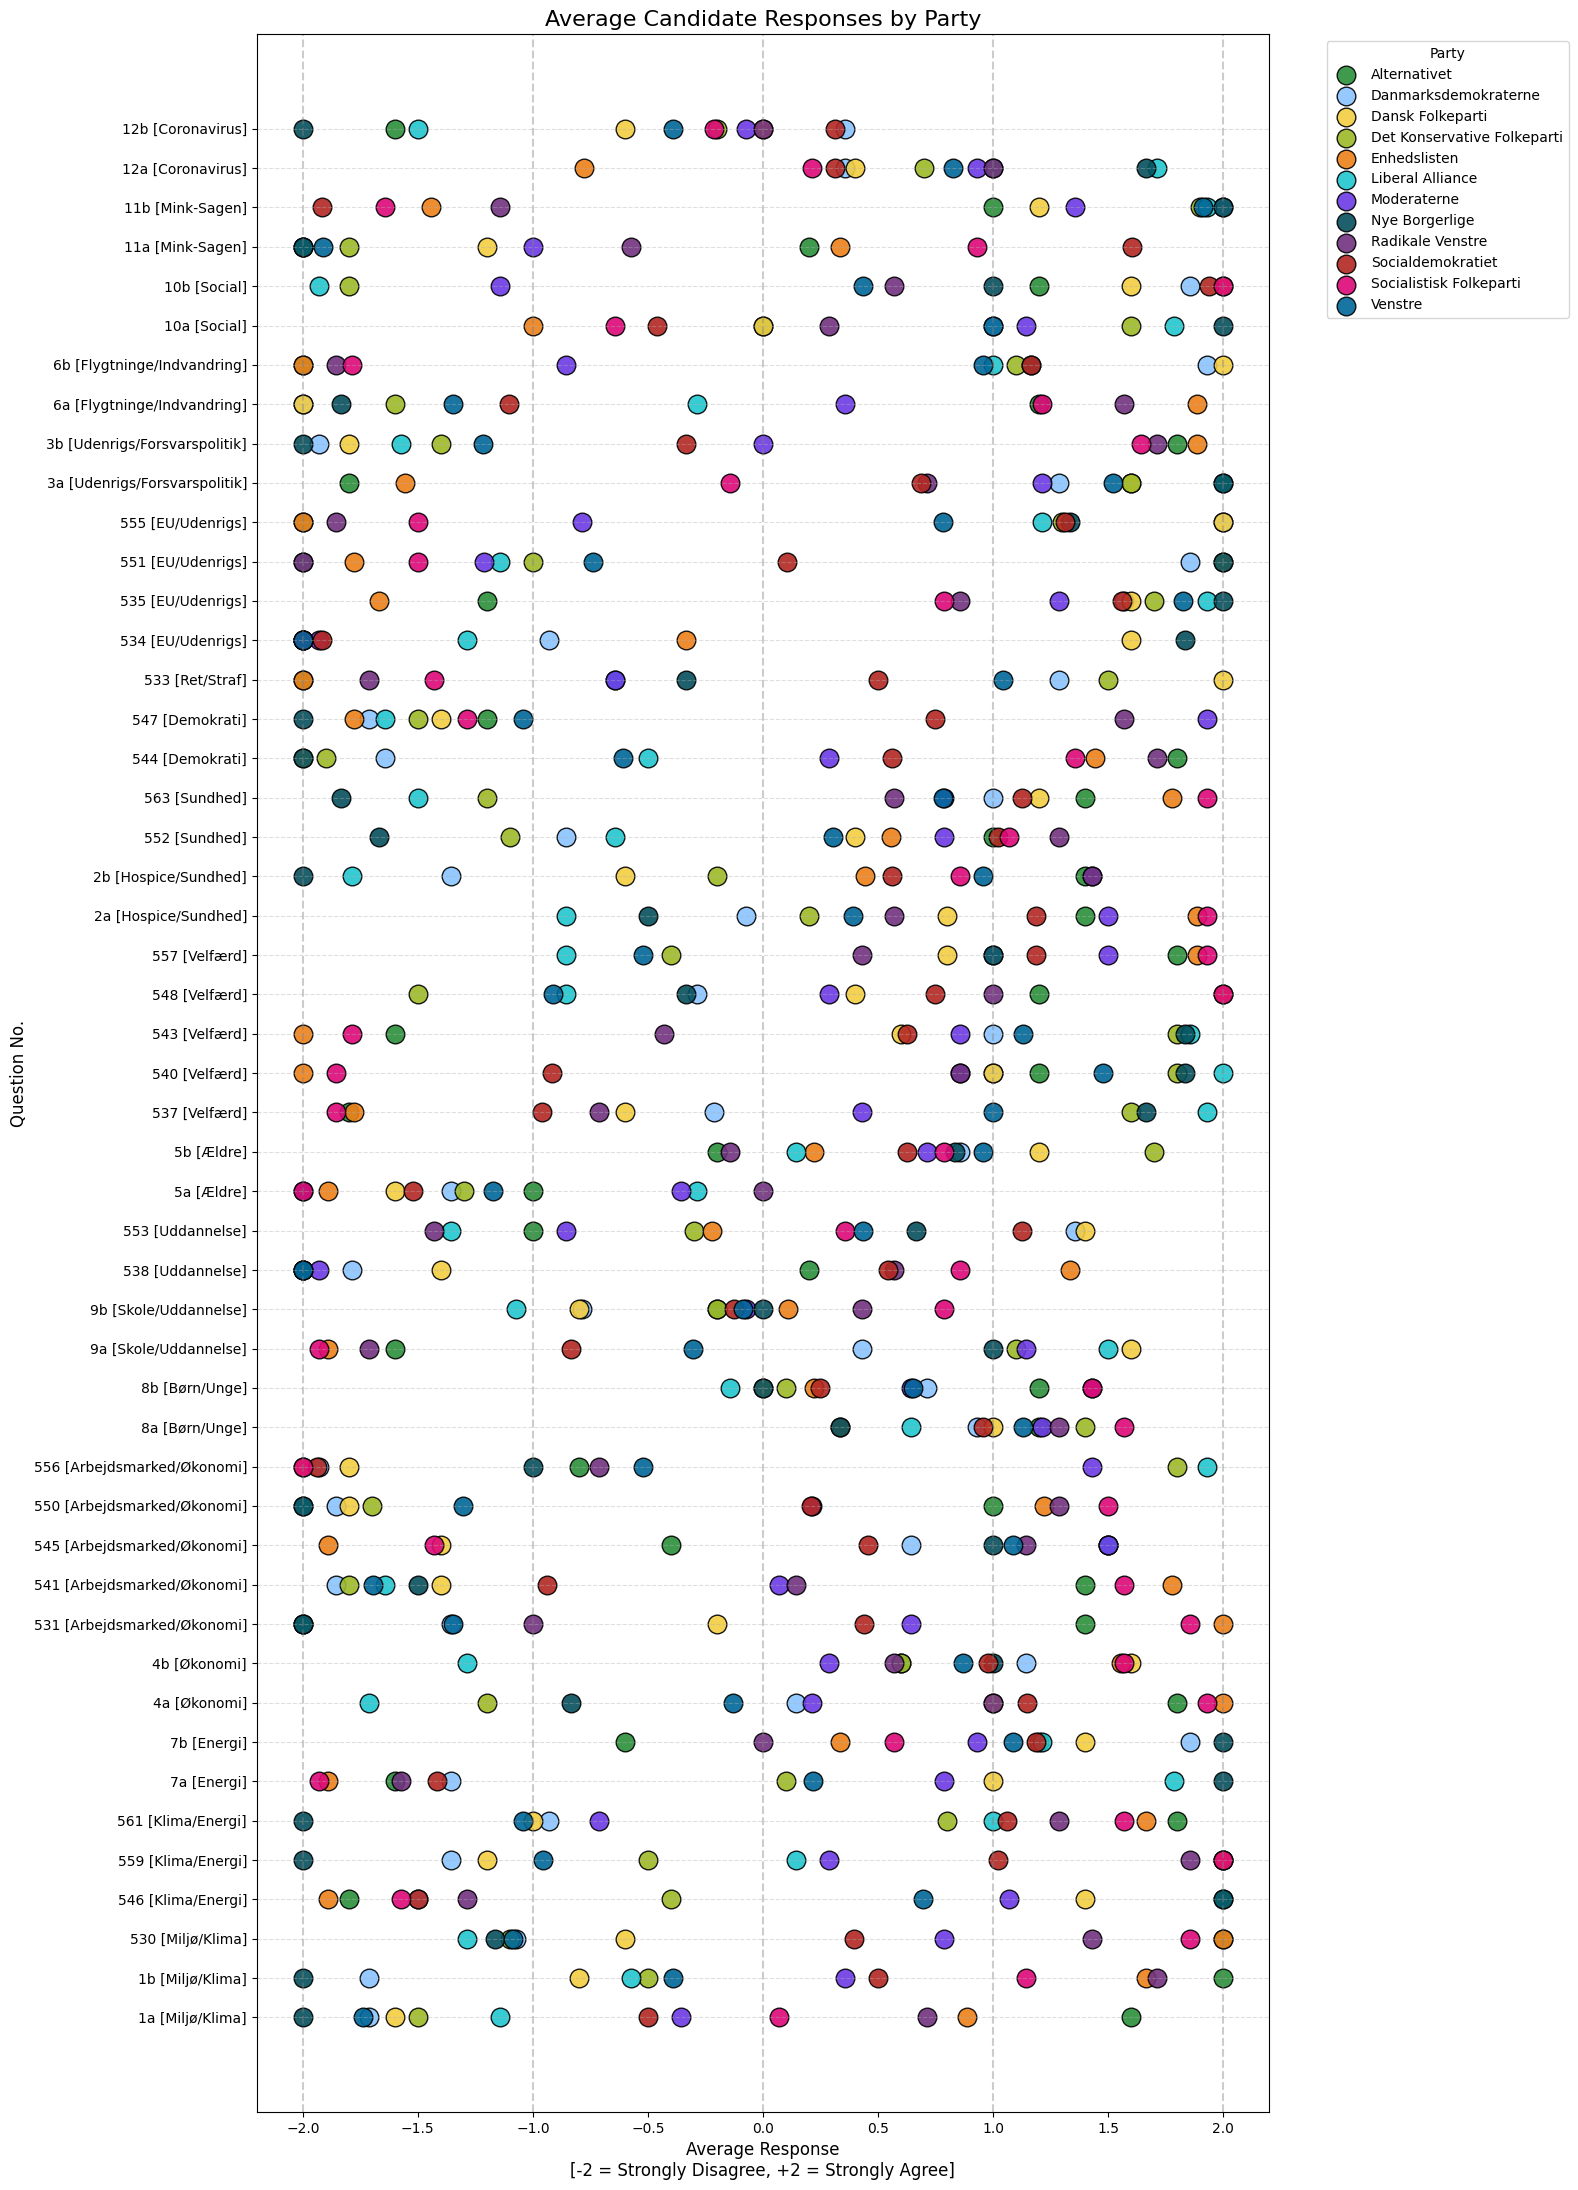

In [43]:
# Let's first prepare the data:
intra_party_response_data = raw_data
intra_party_response_data = intra_party_response_data.drop(columns=['storkreds', 'alder', 'navn'])

# Group the question answers by party and compute statistics:
intra_party_response_data_grouped_by_party = intra_party_response_data.groupby(['parti']).describe()

# Calculate the mean responses per party for each question:
party_mean_reponses = intra_party_response_data.groupby('parti')[question_columns].mean().T

# Create a combined plot for easy visual comparison between parties
print("\nElected Candidate Average Responses visualized for each party:")
fig, ax = plt.subplots(figsize=(16, 22))
y_positions = np.arange(len(party_mean_reponses.index))

for i, party in enumerate(party_mean_reponses.columns):
    color = party_colors.get(party, "#7f7f7f")
    ax.scatter(party_mean_reponses[party], y_positions, label=party, color=color, s=180, edgecolor='black', alpha=0.9)

ax.set_yticks(y_positions)
ax.set_yticklabels(question_labels, fontsize=10)
ax.set_xlabel("Average Response\n[-2 = Strongly Disagree, +2 = Strongly Agree]", fontsize=12)
ax.set_title("Average Elected Candidate Responses by Party", fontsize=16)
ax.set_ylabel("Question No.", fontsize=12)
for x in range(-2, 3):
    ax.axvline(x=x, color='gray', linestyle='--', alpha=0.4)
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.legend(title="Party", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Data Analysis: Which questions are most crucial concerning their placement on the axes.

To identify the most important questions for party placement on the axes, I will be using the dimensionality reduction principles. This can be viewed as a part of the overall data pre-processing, before training a proper model.

For this, a Principal Component Analysis (PCA) will be done. PCA involves identifying the principle components that explain a defined variance. It can be very useful in reducing the number of features in model training to only those that for instance explain 80% to 95% of the variance.

It's important for me to underline that each component in a PCA analysis DOES NOT correspond to each question from the data. Instead, each component is a direction (axis) in the data space, which captures as much of the variance as possible. Each original question is simply a variable (or dimension) in the dataset, where each principal component becomes a weighed combination of all these variables/dimensions, ordered by how much of this they capture.

This principle allows for reducing multiple dimensions/variables/features into much fewer, allowing for much improved data training time without significant loss in accuracy.

The primary workflow is:

    1: Pre-proces data, including:
      a. Ensure only numerical columns remain.
      b. Ensure no rows are missing any values.
    2: Standardize the data, so mean = 0 and the standard variance for each feature/question is 1. (i.e. -1 to 1).
    3: Perform the PCA using sklean framework.
    4: Extract the most important components (those that explain the most variance).



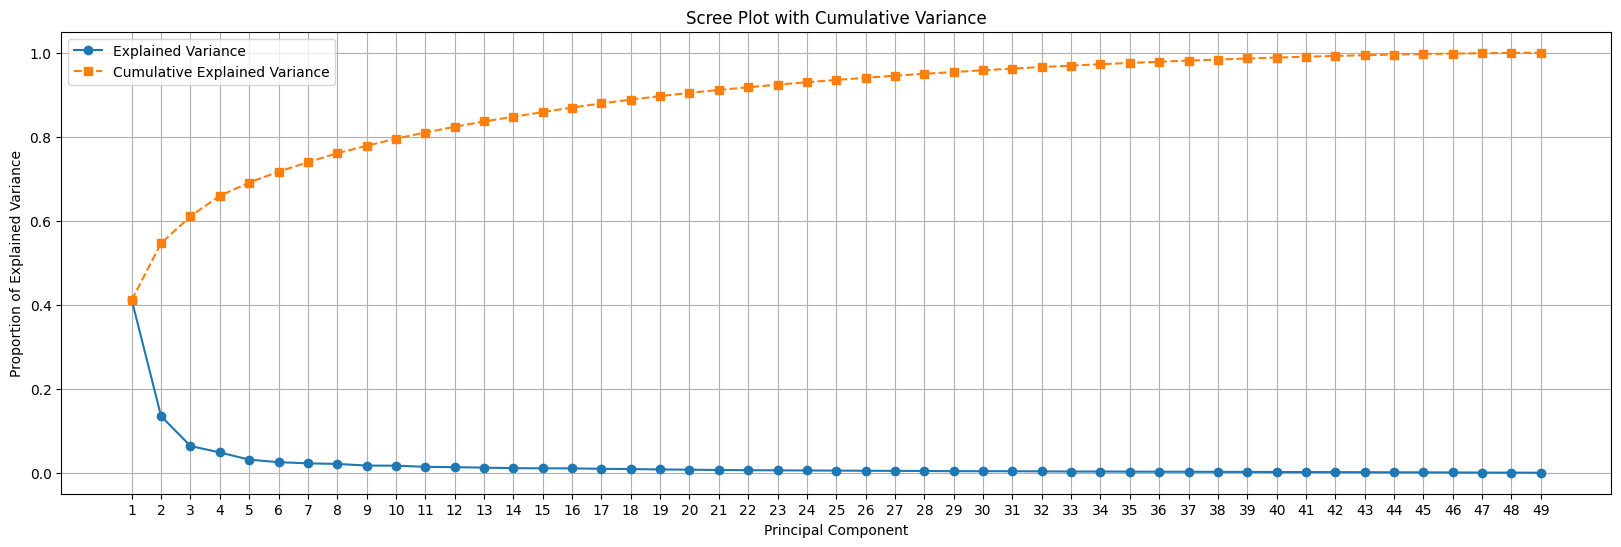



Identifying the elbow point:
For the blue graph we see the elbow point at about 3-5 components.
For the orange graph, we can see the shoulder point also corresponds to about 3-5 components as well.


In [44]:
# 1. Let's first prepare the data:
## Remove non-numerical columns:
X_PCA = raw_data
X_PCA = X_PCA.drop(columns=['storkreds', 'alder', 'navn', 'parti'])

## Remove any rows with missing data:
X_PCA = X_PCA.dropna()


# 2. Standardize the data, so mean = 0 and the standard variance for each feature/question is 1. (i.e. -1 to 1).
scaler = StandardScaler()
X_PCA = scaler.fit_transform(X_PCA)


# 3. Perform the PCA using sklean framework. Keeping all features initially and plot to scree graph, so I can see where the elbow point is:
pca = PCA(n_components=None)
pca.fit(X_PCA)


# 4. Extract and visualize all the components.
X_PCA_explained_variance_ratio = pca.explained_variance_ratio_
X_PCA_cumulative_variance_ratio = np.cumsum(X_PCA_explained_variance_ratio)

plt.figure(figsize=(20, 6))

plt.plot(range(1, len(X_PCA_explained_variance_ratio)+1), X_PCA_explained_variance_ratio, marker='o', label='Explained Variance')
plt.plot(range(1, len(X_PCA_cumulative_variance_ratio)+1), X_PCA_cumulative_variance_ratio, marker='s', linestyle='--', label='Cumulative Explained Variance')

plt.title('Scree Plot with Cumulative Variance')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Explained Variance')
plt.grid(True)
plt.legend()
plt.xticks(np.arange(1, len(X_PCA_explained_variance_ratio) + 1))
plt.show()

print("\n\nIdentifying the elbow point:\nFor the blue graph we see the elbow point at about 3-5 components.\nFor the orange graph, we can see the shoulder point also corresponds to about 3-5 components as well.")

In [45]:
# 5. Re-perform the PCA, using the number of components corresponding with the elbow point:
# Re-performing the PCA, I now set n_components to '5', as identified above.
pca = PCA(n_components=5)
pca.fit(X_PCA)

# 6. List the most important features in the order of importance (most important first):
print("\nTop contributing questions to each principal component:")

# Loop through each component (PC1 to PC5)
for i, component in enumerate(pca.components_):
    print(f"PCA {i+1}:")

    # Match the component weights to feature names and labels
    feature_weights = pd.Series(component, index=question_labels)

    # Sort by absolute value (importance), descending
    sorted_features = feature_weights.abs().sort_values(ascending=False)

    # Print top 2 questions for this principal component
    for idx in sorted_features.head(2).index:
        value = feature_weights[idx]
        print(f" - {idx} (weight: {value:.3f})")
    print()


Top contributing questions to each principal component:
PCA 1:
 - 552 [Sundhed] (weight: 0.193)
 - 563 [Sundhed] (weight: 0.191)

PCA 2:
 - 9b [Skole/Uddannelse] (weight: 0.306)
 - 8b [Børn/Unge] (weight: 0.288)

PCA 3:
 - 550 [Arbejdsmarked/Økonomi] (weight: 0.398)
 - 546 [Klima/Energi] (weight: -0.391)

PCA 4:
 - 3b [Udenrigs/Forsvarspolitik] (weight: 0.401)
 - 533 [Ret/Straf] (weight: 0.355)

PCA 5:
 - 550 [Arbejdsmarked/Økonomi] (weight: 0.326)
 - 546 [Klima/Energi] (weight: 0.317)



In [46]:
# For each row in the computed pca.components_ I now want to compute the absolute weight/importance of each questions.
# Each row in pca.components_ corresponds with a principal component.
# Each column in these rows correspond to how much each question contributes to this component.
# np.abs. ensures all column values are converted to positive values.
components_absolute = np.abs(pca.components_)

# Compute each features overall important across rows.
# setting axis=0 tells the np.sum() method to sum along the columns (y-axis) instead of the x-axis.
overall_importance = np.sum(components_absolute, axis=0)

# Wrap data into a data frame for improved display/printout:
importance_df = pd.DataFrame({
    'label': question_labels,
    'importance': overall_importance
})

# Sort by importance descending:
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Show top N most important questions:
top_n = 10
print(f"Top {top_n} most important questions based on PCA:")
display(importance_df.head(top_n).style.hide(axis="index"))

Top 10 most important questions based on PCA:


label,importance
537 [Velfærd],0.891428
546 [Klima/Energi],0.861933
3a [Udenrigs/Forsvarspolitik],0.814613
550 [Arbejdsmarked/Økonomi],0.791640
533 [Ret/Straf],0.780470
2a [Hospice/Sundhed],0.779659
545 [Arbejdsmarked/Økonomi],0.730465
11a [Mink-Sagen],0.726257
3b [Udenrigs/Forsvarspolitik],0.715591
5a [Ældre],0.691116


## Conclusion:
From the PCA analysis, it is now possible to identify how much each question/feature contributes to the explaining the variance between the parties for each question.

I can see that Question 537 under the Velfærd topic is the most influential question in explaining the interparty differences. Based on these prioritized list I am now able to see which questions are unimportant in the dataset and perhaps now include these when training a model, for improved training speed and reduced compute resource requirements.

<br><br>

# A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**


## Data Pre-processing for Clustering:
I'll be re-building / preparing the data set for Clustering analysis. The PCA reduction above will not be used further, since the data set only consists of ca. 50 questions / features. If the data set had contained 50.000 questions / features, I might have reconsidered this.

For visualizing the data however, I will be using PCA with 2 principle components (one for each axis in 2D), which will allow me to somewhat visually represent the data and clusters - it is simply not possible to represent 49 dimensions in 2D space otherwise...

In [47]:
# 1. Let's first prepare the data:
## Remove non-numerical columns:
X_Cluster = raw_data
X_Cluster = X_Cluster.drop(columns=['storkreds', 'alder', 'navn', 'parti'])

## Remove any rows with missing data:
X_Cluster = X_Cluster.dropna()

# 2. Standardize the data, so mean = 0 and the standard variance for each feature/question is 1. (i.e. -1 to 1).
scaler = StandardScaler()
X_Cluster_Scaled = scaler.fit_transform(X_Cluster)

# For visualization:
pca_visualization = PCA(n_components=2)
X_visualization = pca_visualization.fit_transform(X_Cluster_Scaled)

def plotCluster(fitted_data, graph_name):
  plt.scatter(X_visualization[:, 0], X_visualization[:, 1], c=fitted_data, cmap='rainbow', s=10)
  plt.title(graph_name)
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  plt.grid(True)
  plt.show()

## K-Means:
The principle will be to run the k-means algorithm 10 times (n_init = 10), and picking the best one of these. Centroids will be chosen at random, but with a bias towards picking centroids far from each other (init = 'k-means++').

The Cost Function will be based on the .inertia_ parameter available in sklearns KMeans algorithm. It represents the sum of squared distances between each data point and the centroid of the cluster it is assigned to. A high .inertia_ value indicates loosely grouped data and a low value indicates tightly grouped data.

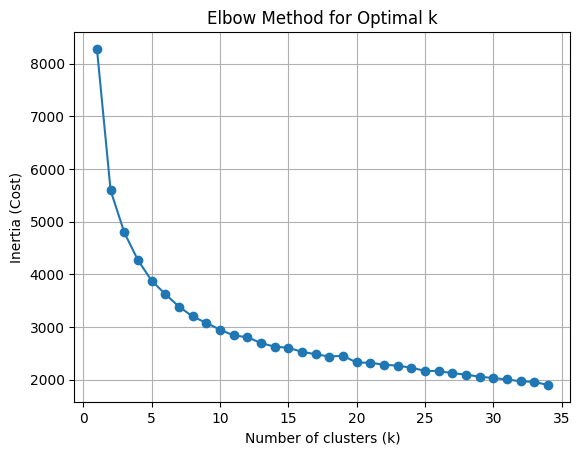

In [48]:
costs = []
k_range = range(1, 35)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=761, init='k-means++', n_init=10)
    kmeans.fit_predict(X_Cluster_Scaled)
    costs.append(kmeans.inertia_)

plt.plot(k_range, costs, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Cost)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

Based on the above visualization of the k-means clusters on this data set, it can be observed that the elbow point lies around 5 clusters. Equaling 1 cluster to 1 party, this means that the current cluster algorithm finds the optimal number of political parties to be around 5 before significant variances become less significant.

I can now finalize the first iteration of the k-means clustered data/model:




In [49]:
cluster = KMeans(random_state=761, n_clusters=5, n_init = 10, init='k-means++')
y_prime = cluster.fit_predict(X_Cluster_Scaled)

## Hierarchical Clustering (Agglomerative clusters)
I will now use this methodology to analyze/explore how the parties/politicians merge in a hierarchical manner. Using this principle, nodes are evaluated sequentially for each iteration, expanding either already existing cluster or creating new clusters until only 1 cluster remains. This allows for deeper insight into how and when data mergers, and especially how significant variances between clusters are.

The main goal is to corroborate/contest whether the 5 primary clusters (parties) identified in the initial k-means analysis is a good number.

I'll be attempting 4 different approaches to connecting the nodes into clusters:
1. 'single': Uses the min. distance between nodes to build clusters.
2. 'complete': Uses the max. distance between nodes to build clusters.
3. 'average': Uses the avg. distance between nodes to build clusters.
4. 'ward': Calculates the 'cost increase' after each connection and uses this to measure how/when to combine nodes/clusters.

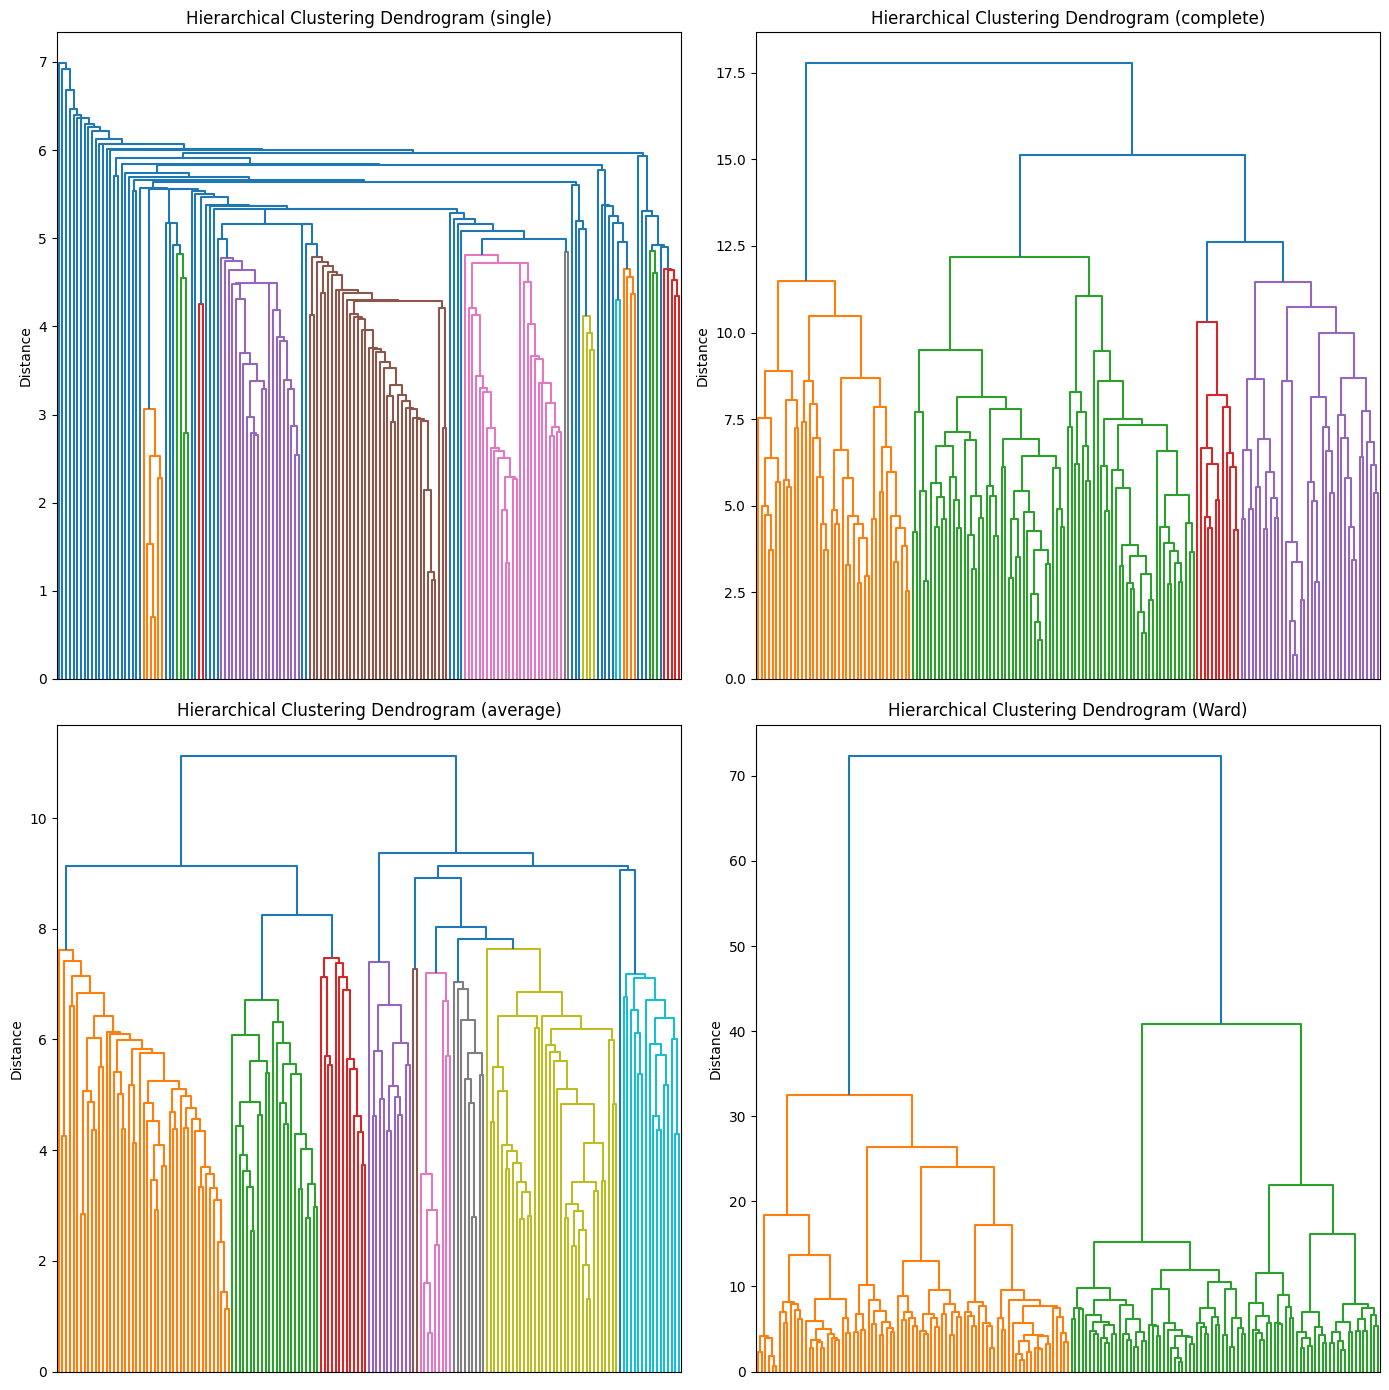

In [50]:
# Preparation for display:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))  # 2 row, 2 columns
axes = axes.flatten()

# The 'single' graph:
linkage_array = linkage(X_Cluster_Scaled, method='single')
dendrogram(linkage_array, ax=axes[0], no_labels=True)
axes[0].set_title('Hierarchical Clustering Dendrogram (single)')
axes[0].set_ylabel('Distance')
#plt.show()

# The 'complete' graph:
linkage_array = linkage(X_Cluster_Scaled, method='complete')
dendrogram(linkage_array, ax=axes[1], no_labels=True)
axes[1].set_title('Hierarchical Clustering Dendrogram (complete)')
axes[1].set_ylabel('Distance')
#plt.show()


# The 'average' graph:
linkage_array = linkage(X_Cluster_Scaled, method='average')
dendrogram(linkage_array, ax=axes[2], no_labels=True)
axes[2].set_title('Hierarchical Clustering Dendrogram (average)')
axes[2].set_ylabel('Distance')
#plt.show()


# The 'ward' graph:
linkage_array = linkage(X_Cluster_Scaled, method='ward')
dendrogram(linkage_array, ax=axes[3], no_labels=True)
axes[3].set_title('Hierarchical Clustering Dendrogram (Ward)')
axes[3].set_ylabel('Distance')

# Display graphs:
plt.tight_layout()
plt.show()

Evaluating the generated Dendrograms, the following conclusions can be made for each method:

- 'single': Does not produce a useful dendrogram. Using min. distance as the basis for clustering does not yield a readily readable analysis. As such I disregard these results entirely.
- 'complete': Yields a useful dendrogram, that can be readily understood. Drawing a horizontal line at distance=12.0, it is possible to confirm that everything above 3-5 clusters does not yield significant differences between the clusters/parties.
- 'average': Yields a somewhat useful dendrogram. Significant drops are however still hard to visually separate, due to the large data set. This dendrogram is inconclusive, as significant leaps in cluster variance is quite small. If a clustering number should be identified, it would be between 2 and 7.
- 'ward': Yields a useful dendrogram. Placing the distance at about 25, I can see that significant drops in cluster variance decreases at about 3-6 clusters.

Overall: Both 'complete' and 'ward' methodologies support the results from k-means, identifying 5 primary significantly different clusters/parties. 'single' and 'average' methodologies were inconclusive.


## DBSCAN
'Density-Based Spacial Clustering of Applications with Noise' (DBSCAN) is an algorithm I can use to identify core clusters based on local density, as well as automatically detecting the number of clusters. Using this, I am able to flag outliers and non-conforming data entries (politicians).

Using this approach I will be able to further corroborate or challenge whether the above identified 5 significant clusters (parties) holds true, and if there are any not readily visible sub-clusters (parties) or political outliers that do not fit into these main parties.

The principle is to:
1. Identify the number of nodes that should lie closely together. A rule of thumb is to use the double of the number of dimensions/features. There are 49 questions, so I'll be using min_samples=98.
2. If a node has at least 'min_samples' nodes within a distance 'eps' it becomes a 'core' node.
3. All core nodes are connected within distance 'eps'.
4. All nodes that lie within distance 'eps' of a core node become 'border points'
5. All other nodes become noise.

First I'll need to analyse what a good epsilon value is. For this I'll be visualizing the distance to n-nearest neighbor for each sample, sorted by dn. From this I'll hopefully be able to pinpoint the elbow point and select the corresponding distance (epsilon) value from there.

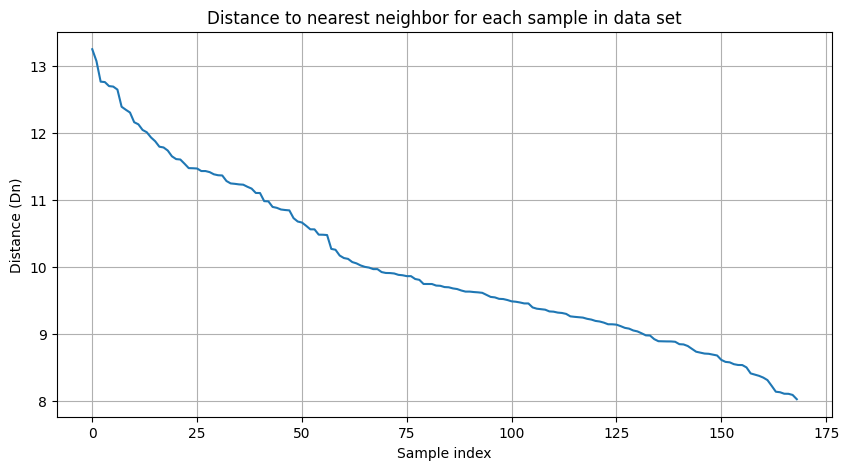

In [51]:
# Functions:
def init_nth_lowest(n):
  return np.full(n, math.inf).tolist()

def add_to_nth_lowest(lowest, _value):
  lowest.append(_value)
  lowest.sort()
  lowest.pop()

def nth_lowest_distance(n, point, points):
  lowest = init_nth_lowest(n)
  for p in points:
    distance = np.linalg.norm(point - p)
    add_to_nth_lowest(lowest, distance)
  return lowest[-1]

def nth_lowest_distances(n, points):
  return [nth_lowest_distance(n, point, points) for point in points]

# Estimating a good epsilon value:
min_samples = 98
distances = nth_lowest_distances(min_samples-1, X_Cluster_Scaled)
distances.sort(reverse=True)

# Display graph:
plt.figure(figsize=(10, 5))
plt.title('Distance to nearest neighbor for each sample in data set')
plt.xlabel('Sample index')
plt.ylabel('Distance (Dn)')
plt.plot(range(len(distances)), distances)
plt.grid(True)
plt.show()

Observing the plotted graph, a specific elbow point proves difficult to identify. But somewhere around epsilon=10 significant drops seem to slow. I'll be using epsilon=10 as my value going forward.

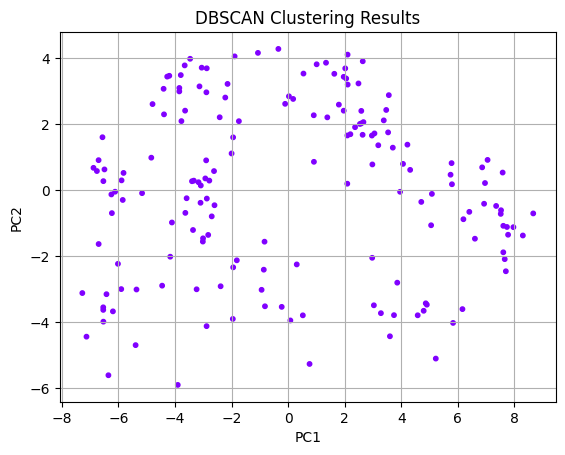

Estimated number of clusters: 1
Number of noise points: 0


In [65]:
db = DBSCAN(eps=10, min_samples=min_samples)
y_prime = db.fit_predict(X_Cluster_Scaled)

plotCluster(y_prime, "DBSCAN Clustering Results")

n_clusters = len(set(y_prime)) - (1 if -1 in y_prime else 0) # Outliers have a value of -1. Subtracts 1 for each noise point, ending up with the number of clusters left.
print(f"Estimated number of clusters: {n_clusters}")

# Optional: Count how many samples are considered noise
n_noise = list(y_prime).count(-1)
print(f"Number of noise points: {n_noise}")

This yields 1 primary cluster and about 0% of the data set as noise (out of ca. 169 samples). The noise amount seems quite large.

Taking the 'Curse of Dimensionality' into considering, which says that Machine learning models become worse at generalizing the higher the number of dimensions become, as well as the fact that data points quickly all become outliers, I'll try to reduce the number of dimensions and re-run a DBSCAN to see if that yields significantly other results.

I'll use PCA to reduce the number of dimensions to 5, as identified earlier during the agglomerative clustering analysis.

I'll also reduce the min_samples to 5, since my data set is not that large (169 samples)

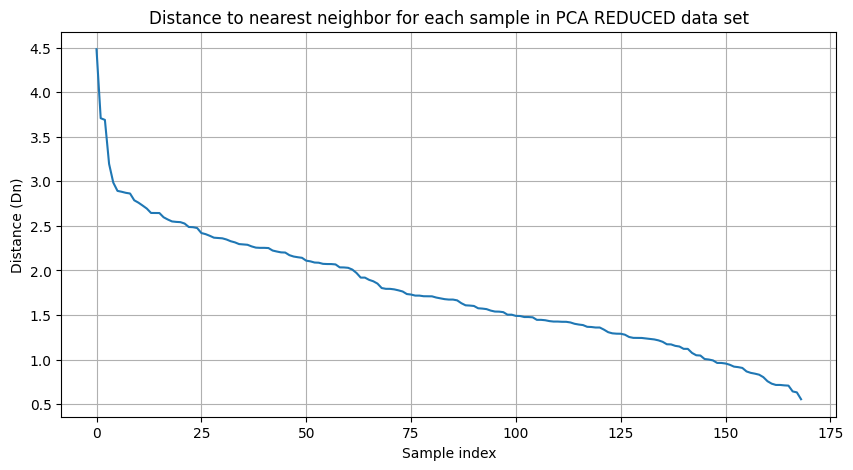

In [81]:
# PCA Reduction:
pca_dbScanRed = PCA(n_components=5)
X_Cluster_Scaled_Red = pca_dbScanRed.fit_transform(X_Cluster_Scaled)

# Estimating a good epsilon value. Decrease min_samples to 10 (double of 5 components)
min_samples = 5
distances = nth_lowest_distances(min_samples-1, X_Cluster_Scaled_Red)
distances.sort(reverse=True)

# Display graph:
plt.figure(figsize=(10, 5))
plt.title('Distance to nearest neighbor for each sample in PCA REDUCED data set')
plt.xlabel('Sample index')
plt.ylabel('Distance (Dn)')
plt.plot(range(len(distances)), distances)
plt.grid(True)
plt.show()

The elbow points becomes easier to identify now, lying around eps=2.25.

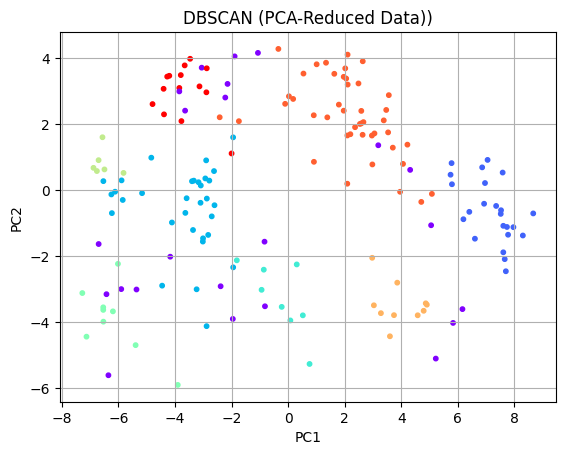

Estimated number of clusters: 8
Number of noise points: 23


In [82]:
db = DBSCAN(eps=2.25, min_samples=min_samples)
y_prime = db.fit_predict(X_Cluster_Scaled_Red)

plotCluster(y_prime, "DBSCAN (PCA-Reduced Data))")

n_clusters = len(set(y_prime)) - (1 if -1 in y_prime else 0) # Outliers have a value of -1. Subtracts 1 for each noise point, ending up with the number of clusters left.
print(f"Estimated number of clusters: {n_clusters}")

# Count how many samples are considered noise:
n_noise = list(y_prime).count(-1)
print(f"Number of noise points: {n_noise}")

Picking the shoulder point on the PCA reduced data set did in fact improve the number of clusters - but significantly worsened the noise.

A final approach would be to keep min_samples, and test the 'eps' values from 0 to 4.5 and see if another eps value exists where the noise is lower, while the number of clusters remains higher than the initial DBSCAN. This will utilize the principles from GridSearch.



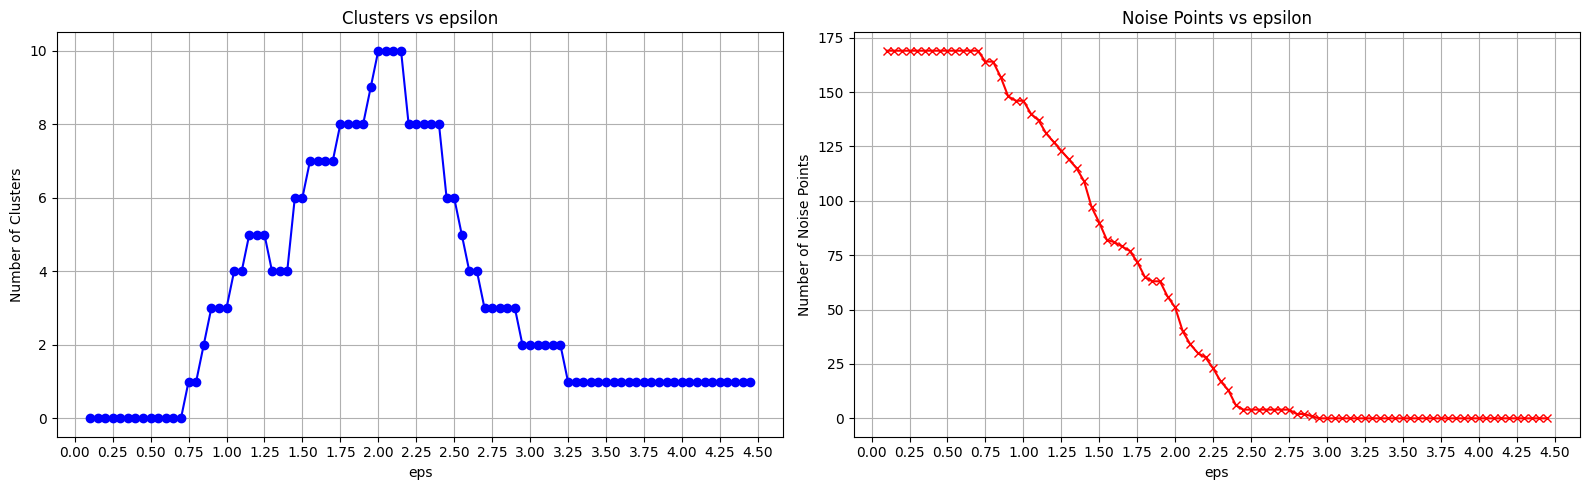

In [83]:
# Grid search settings
min_samples = 5
eps_range = np.arange(0.1, 4.5, 0.05)

results = []

for eps in eps_range:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_Cluster_Scaled_Red)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    results.append((eps, n_clusters, n_noise))

eps_values = [r[0] for r in results]
cluster_counts = [r[1] for r in results]
noise_counts = [r[2] for r in results]

x_ticks = np.arange(0, 4.75, 0.25)
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(eps_values, cluster_counts, marker='o', color='blue')
plt.title('Clusters vs epsilon')
plt.xlabel('eps')
plt.ylabel('Number of Clusters')
plt.xticks(x_ticks)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(eps_values, noise_counts, marker='x', color='red')
plt.title('Noise Points vs epsilon')
plt.xlabel('eps')
plt.ylabel('Number of Noise Points')
plt.xticks(x_ticks)
plt.grid(True)

plt.tight_layout()
plt.show()

Finer analysis reveals that the noise can be further reduced by increasing epsilon to around 2.4, which would maintain the identified number of clusters, but further reduce the noise to a very neglible amount. This result seems much more balanced - and indeed an improvement over the initially analysed DBSCAN. Let's try to visualize these clusters using the new eps value.

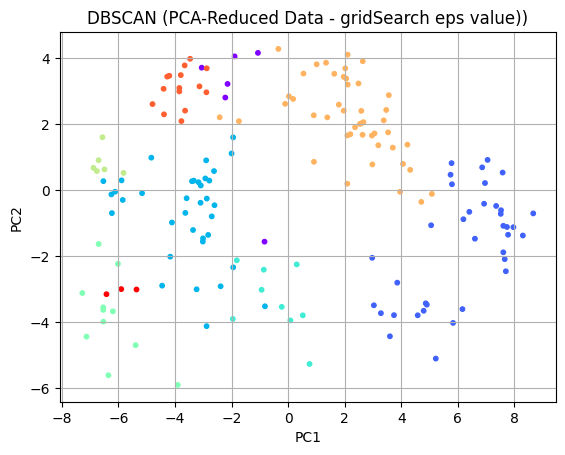

Estimated number of clusters: 8
Number of noise points: 6


In [84]:
db = DBSCAN(eps=2.4, min_samples=min_samples)
y_prime = db.fit_predict(X_Cluster_Scaled_Red)

plotCluster(y_prime, "DBSCAN (PCA-Reduced Data - gridSearch eps value))")

n_clusters = len(set(y_prime)) - (1 if -1 in y_prime else 0) # Outliers have a value of -1. Subtracts 1 for each noise point, ending up with the number of clusters left.
print(f"Estimated number of clusters: {n_clusters}")

# Count how many samples are considered noise:
n_noise = list(y_prime).count(-1)
print(f"Number of noise points: {n_noise}")

### Conclusion:
K-Means found an optimal number of clusters/parties to be 5.
Agglomerative Clustering supported this number.
DBSCAN above ended at a balanced 8 clusters, while still identifying 6/169 (ca. 4%) of the data points as noise.

Overall the analysis methods seems to support the optimal number of parties, based on the current elected candidates answers, to be around 5-8 primary parties. The DBSCAN indicates that there is very little room for more as only about 4% of the candidates do not fall within these 5-8 primary parties. Considering that there are currently 14 political parties, a reduction in political parties would be optimal, as shown by the clustering - at least to somewhere between 5 - 8 parties, potentially even further reduced. However, one must also remember that this is just numbers and science, in actuality the most important thing in a democracy is to have elected candidates that genuinely represent the voters - even if that collides with numbers and calculations!



# An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.

To approach this task, I'll be breaking it into 2 sub-tasks:
1. Identifying which members agree/disagree the most internally in each party. This will be compared to the party mean answers.
2. Identifying which parties have the most/the least internal disagreement amongst their elected candidates.


## Identifying which members agree/disagree the most internally in each party. This will be compared to the party mean answers.

This sub-task will be approached by;
1. Pre-processing data, including scaling it.
2. Computing the euclidian distance between each politician's response vector and their party's average.
3. Sorting all responses, to identify the most diverging members.
4. Displaying the top 10 most aligned and least aligned elected candidates.

In [85]:
# Data Pre-Processing:
# 1. Let's first prepare the data:
## Remove non-numerical columns:
X = pd.read_excel('electeddata.xlsx')
X = X.drop(columns=['storkreds', 'alder', 'navn'])

## Remove any rows with missing data:
X_clean = X.dropna()

## Standardize the data, so mean = 0 and the standard variance for each feature/question is 1. (i.e. -1 to 1):
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean.drop(columns=['parti']))

## Rebuild scaled data into a dataframe and calculate party means.
X_scaled_df = pd.DataFrame(X_scaled, columns=X_clean.columns.drop('parti'), index=X_clean.index)
X_scaled_df['parti'] = X_clean['parti']

## Compute Party means:
party_mean_responses_scaled = X_scaled_df.groupby('parti').mean()
print("Scaled party mean responses:")
display(party_mean_responses_scaled)

# 2. Compute the euclidian distance between each politician's response vector and their party's average:
## In order to calculate the distance between each elected candidate and their party avg, I'll be using the euclidian distance calculation, which simply calculates the distance between two points in each dimension (49 dimensions)
## The principle is to calculate the square root of the total sum of squared differences across all dimensions
distances = []
for idx, row in X_scaled_df.drop(columns='parti').iterrows():
    party = X_scaled_df.loc[idx, 'parti']
    party_avg = party_mean_responses_scaled.loc[party]
    distance = euclidean(row, party_avg)
    distances.append((idx, raw_data.loc[idx, 'navn'], party, distance, party_avg))

# Convert to dataframe for easier sorting and display:
distance_df = pd.DataFrame(distances, columns=['index', 'name', 'parti', 'distance_to_party_mean', 'party_mean_vector'])

# Sort results by agreement:
distance_df_sorted = distance_df.sort_values(by='distance_to_party_mean').reset_index(drop=True)

# Print most aligned members:
print("\n\nTop 10 most aligned (in agreement) members with each party's average responses:")
display(distance_df_sorted.head(10))
print()

# Print least aligned members:
print("\n\nTop 10 least aligned (in agreement) members with each party's average responses:")
display(distance_df_sorted.tail(10))

Scaled party mean responses:


,530,531,533,534,535,537,538,540,541,543,...,8a,8b,9a,9b,10a,10b,11a,11b,12a,12b
parti,,,,,,,,,,,,,,,,,,,,,
Alternativet,1.411922,1.072751,-1.410449,-0.490046,-2.365455,-1.174478,0.581059,0.629196,1.485911,-1.536807,...,0.266649,0.862205,-1.030638,-0.050174,-0.345932,0.253280,0.343707,0.471087,0.408812,-1.222509
Danmarksdemokraterne,-0.857082,-0.754208,0.833684,0.541737,0.273686,-0.043122,-0.774957,0.493566,-0.807780,0.357898,...,-0.130480,0.271431,0.523153,-0.780542,0.513810,0.687362,-1.018664,1.020147,-0.264135,0.524914
Dansk Folkeparti,-0.508816,0.012547,1.321538,2.976747,0.300894,-0.318316,-0.511558,0.493566,-0.485859,0.066405,...,-0.025972,-0.597354,1.420413,-0.798356,-0.345932,0.517503,-0.523256,0.580899,-0.219272,-0.329665
Det Konservative Folkeparti,-0.878189,-1.180183,0.980040,-0.490046,0.396121,1.251313,-0.921289,1.036088,-0.767540,0.940884,...,0.559271,-0.475724,1.037437,-0.050174,1.029656,-1.728399,-0.894812,0.965241,0.094770,0.027472
Enhedslisten,1.411922,1.470328,-1.410449,1.114951,-2.809847,-1.158623,1.354996,-1.540889,1.751943,-1.828300,...,-1.001377,-0.327065,-1.251914,0.337772,-1.205674,0.781727,0.426275,-0.871060,-1.452177,0.206041
Liberal Alliance,-1.015385,-1.180183,-0.483525,0.197809,0.613782,1.485738,-0.921289,1.171718,-0.656879,0.982526,...,-0.548511,-0.771111,1.343818,-1.136819,1.189322,-1.813328,-1.018664,0.980929,1.156530,-1.133225
Moderaterne,0.514874,0.571047,-0.483525,-0.421261,0.001610,0.415536,-0.872512,0.396687,0.550326,0.253794,...,0.287551,0.184553,1.070263,0.110151,0.636631,-1.294317,-0.399404,0.667180,0.334040,0.142266
Nye Borgerlige,-0.927439,-1.180183,-0.272121,3.201446,0.681801,1.298877,-0.921289,1.058693,-0.556279,0.965175,...,-1.001377,-0.597354,0.960841,0.199220,1.373552,0.121168,-1.018664,1.020147,1.106682,-1.579646
Radikale Venstre,0.989781,-0.517556,-1.215307,-0.490046,-0.406505,-0.399856,0.834702,0.396687,0.600627,-0.683148,...,0.392058,1.140217,-1.118176,0.733635,-0.100291,-0.161929,-0.134007,-0.705470,0.408812,0.206041




Top 10 most aligned (in agreement) members with each party's average responses:


,index,name,parti,distance_to_party_mean,party_mean_vector
0,108,Pernille Vermund,Nye Borgerlige,1.253302,530 -0.927439 531 -1.180183 533 -0.27212...
1,130,Peter Seier Christensen,Nye Borgerlige,1.253302,530 -0.927439 531 -1.180183 533 -0.27212...
2,55,Kim Edberg,Nye Borgerlige,1.532308,530 -0.927439 531 -1.180183 533 -0.27212...
3,147,Mette Thiesen,Nye Borgerlige,1.930035,530 -0.927439 531 -1.180183 533 -0.27212...
4,156,Karen Ellemann,Venstre,1.943682,530 -0.868553 531 -0.748035 533 0.66823...
5,2,Mai Villadsen,Enhedslisten,2.043448,530 1.411922 531 1.470328 533 -1.41044...
6,86,Thomas Danielsen,Venstre,2.046629,530 -0.868553 531 -0.748035 533 0.66823...
7,119,Peter Skaarup,Danmarksdemokraterne,2.115329,530 -0.857082 531 -0.754208 533 0.83368...
8,6,Jakob Ellemann-Jensen,Venstre,2.128818,530 -0.868553 531 -0.748035 533 0.66823...
9,73,Mikkel Bjørn,Nye Borgerlige,2.161297,530 -0.927439 531 -1.180183 533 -0.27212...





Top 10 least aligned (in agreement) members with each party's average responses:


,index,name,parti,distance_to_party_mean,party_mean_vector
159,116,Benny Engelbrecht,Socialdemokratiet,5.799441,530 0.226851 531 0.434972 533 0.29704...
160,12,Jens Meilvang,Liberal Alliance,5.822264,530 -1.015385 531 -1.180183 533 -0.48352...
161,78,Bjørn Brandenborg,Socialdemokratiet,5.985668,530 0.226851 531 0.434972 533 0.29704...
162,133,Frederik Vad,Socialdemokratiet,6.025870,530 0.226851 531 0.434972 533 0.29704...
163,166,Maria Durhuus,Socialdemokratiet,6.102352,530 0.226851 531 0.434972 533 0.29704...
164,31,Jan E. Jørgensen,Venstre,6.120396,530 -0.868553 531 -0.748035 533 0.66823...
165,75,Kim Aas,Socialdemokratiet,6.174618,530 0.226851 531 0.434972 533 0.29704...
166,43,Mette Reissmann,Socialdemokratiet,6.923617,530 0.226851 531 0.434972 533 0.29704...
167,33,Jon Læssøe Stephensen,Moderaterne,6.978855,530 0.514874 531 0.571047 533 -0.48352...
168,126,Lars-Christian Brask,Liberal Alliance,7.780086,530 -1.015385 531 -1.180183 533 -0.48352...


## Identifying which parties have the most/the least internal disagreement amongst their candidates.

Based on the above identified elected candidates with the most/the least disagreement with their parties, I can now build a further analyse how this correlates between the parties. The approach to answer this question will consist of:
1. Visualizing a boxplot of the elected candidates agreement/disagreement for each party, showing outliers and Q1 to Q4 values.
2. Using PCA to reduce and visualize the found multi-dimension elected candidate scores in a manner that can be understood in 2 dimensions (with 2 principle components).


Age distribution visualized


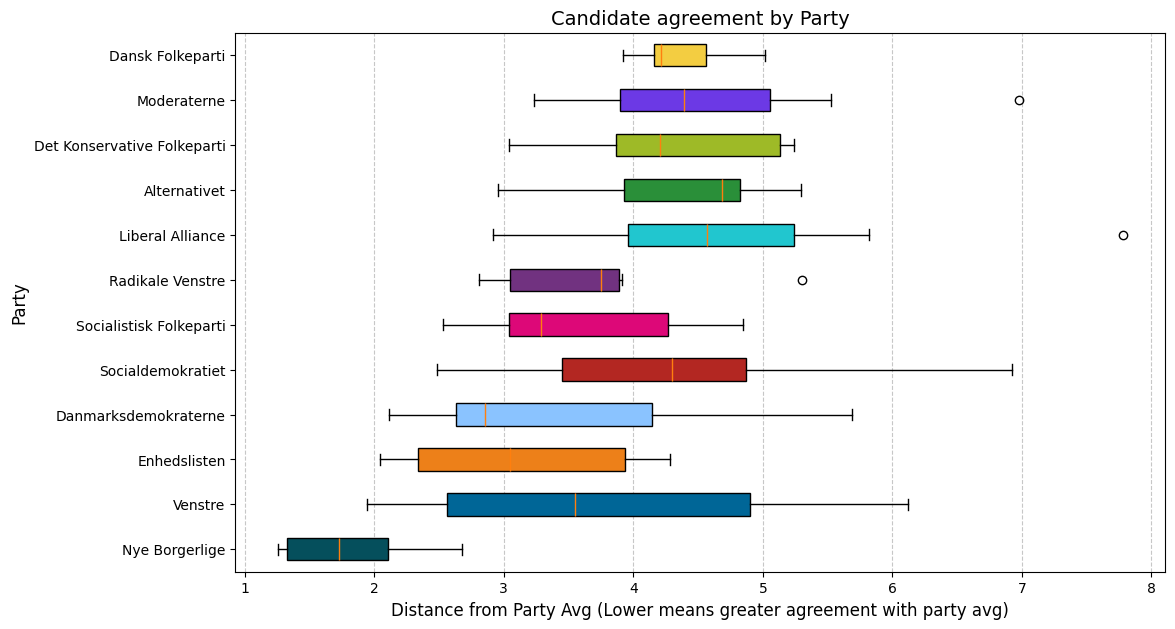

In [58]:
# Box-plotting the elected candidate agreeableness:
print("\nAge distribution visualized")
parties = distance_df_sorted['parti'].unique()
data = [distance_df_sorted.loc[distance_df_sorted['parti'] == party, 'distance_to_party_mean'] for party in parties]

plt.figure(figsize=(12, 7))
box = plt.boxplot(data, vert=False, patch_artist=True, tick_labels=parties)

for patch, label in zip(box['boxes'], parties):
    color = party_colors.get(label, "#7f7f7f")
    patch.set_facecolor(color)

plt.xlabel("Distance from Party Avg (Lower means greater agreement with party avg)", fontsize=12)
plt.ylabel("Party", fontsize=12)
plt.title("Elected Candidate agreement by Party", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

Sorted by most disagreement with "party" at the to the party with the most candidates in agreement, we see that Løsgængere are at the top of the most disagreeable candidates. This seems rational, since they don't belong to a single party - and as such should be expected at this end.

On the other end of scale, we find Nye Borgerlige as the party with its elected candidates most in agreement with the party line, closely followed by Venstre. The spread amongst internal agreement/disagreement shows that while Nye Borgerlige might have candidates which on average are closer aligned with the party line, they still maintain a number of candidates who somewhat disagree. Looking at the graph we see that Radikale Venstre for instance have less internal disagreement, since their "box plot" with 50% (Q2-Q3) is slightly smaller than Nye Borgerliges, as well as their overall spread being less.

Now I'll perform a PCA analysis to verify if these observations also can be identified in the clustering of the elected candidates based on their 'distance_to_party_mean', calculated earlier.

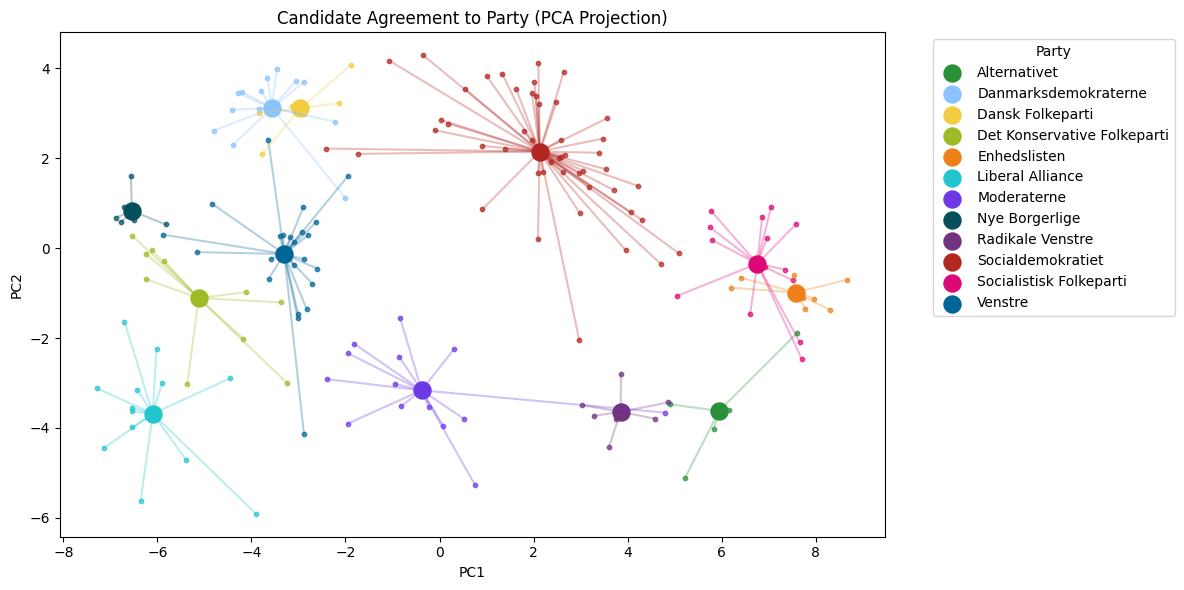

In [87]:
# Apply PCA:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Ensure to have party averages added as well:
party_means_pca = pca.transform(party_mean_responses_scaled)

# Since the X_pca scaled data nor party_means_pca contain 'navn', 'alder' or 'storkreds', I need to re-map some of these values to be able to identify each elected candidate.
party_means_pca_df = pd.DataFrame(party_means_pca, index=party_mean_responses_scaled.index, columns=['PC1', 'PC2'])
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
X_pca_df['parti'] = X_scaled_df['parti'].values
X_pca_df['navn'] = raw_data.loc[X_scaled_df.index, 'navn']

plt.figure(figsize=(12, 6))

# Plot each elected candidate and line to their party centroid:
for idx, row in X_pca_df.iterrows():
    party = row['parti']
    name = row['navn']
    x, y = row['PC1'], row['PC2']
    px, py = party_means_pca_df.loc[party]

    color = party_colors.get(party, '#888888')
    plt.plot([x, px], [y, py], color=color, alpha=0.3)  # Line to centroid
    plt.scatter(x, y, color=color, s=10, alpha=0.7)  # Elected Candidate

# Plot party centroids:
for party, row in party_means_pca_df.iterrows():
    px, py = row['PC1'], row['PC2']
    color = party_colors.get(party, '#000000')
    plt.scatter(px, py, color=color, s=150, marker='o', label=party)

plt.title("Elected Candidate Agreement to Party (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Party", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Reviewing the clustering above, I can clearly see how the elected candidates for each party seem to be visibly clustered with each other. It's clear to see why the k-means, agglomerative clustering and DBSCAN had trouble identifying all 14 distinct parties, since multiple parties are weaved into each other. A sort of right vs. left wing division can also be observed, where traditional left wing parties are clustered towards the right, while traditional right-wing parties are clustered towards the left.

# Overall Conclusions

I have now displayed how Clustering principles such as k-means, agglomerative clustering and DBSCAN can be utilized in the analysis of data as well as the training of a model capable of predictions (k-means). I have displayed how Principle Component Analysis can be utilized for dimensionality reduction, where we can better tackle the curse of dimensionality through a qualified reduction of dimensions/features in the data set. I have also displayed how PCA can help in visualizing multidimensional data, improving understanding through visual inspection.

Working through this assignment, I have:
1. Identified how each party aligns with each questions, compared to each other - using statistics.
2. Identified the most crucial/important questions that influence where each party is placed on the axis between 'strong disagreement' to 'strong agreement'.
3. A clustering analysis, attempting to see if elected candidates would cluster in accordance with their actual parties - or in accordance with some other placement, using basic clustering methods (k-means, agglomerative clustering and DBSCAN).
4. Displayed an overview of the political landscape of the elected candidates, showcasing how much each parties elected officials agree or disagree with each other - as well as how this correlates between parties.